## Friend-to-friendネットワークにおける効率的な分散ルーティング

#### 非線形物理学講座　理論神経科学・非平衡系数理グループ
#### B4髙橋彰

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from math import log
import random, logging, sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from utils.gen import kleinberg_ring
from utils.search import greedy_path, average_greedy_path_length, RoutingError
from utils.misc import shuffle_position_ring, dist_ring, labels_from_attr

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

def draw_autocrop(G):
    pos = nx.circular_layout(G)
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-xmax,xmax)
    plt.ylim(-ymax,ymax)
    return pos
def draw_autocrop_grid(G):
    pos = dict(zip(G,G))
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-0.3,xmax)
    plt.ylim(-0.3,ymax)
    return pos

# 1. 研究の動機


### 背景①
- Small-world network - Watts, Strogatz(1998)
    - 高いクラスタリング係数: $CC$
    - 小さな平均最短経路長: $O(\log n)$
    - 送電網、脳神経、友人関係のネットワーク等現実世界の様々なネットワーク構造に現れる特徴

- Navigable small-world network - Kleinberg(2000)
    - 分散的かつ効率的なルーティングを可能にするスモール・ワールドネットワークのモデル
    - P2Pネットワークにおけるルーティングアルゴリズムに応用可能

### 背景②
- Friend-to-friend(F2F)network, Darknet - Clarke et.al(2000, 2009)
    - P2Pネットワークの一形態
    - ネットワーク上の各ノードは、信頼のおける特定ノードとのみ直接の通信を行う
    - 匿名性やプライバシーコントロールレベルの向上を目的とする
    - ネットワーク上で隣接していないノード同士がデータの送受信を行うために複数ノードを中継(c.f. プロキシ)
    - 知り合い関係のネットワークがスモール・ワールド性を持つことを利用
    - 実装例: Freenet 0.7 or 0.7.5, Retroshare, GNUNet
- F2Fネットワークの課題
    1. 効率性
        - 現実のネットワークトポロジーと理想的なモデルの相違からルーティングが失敗する場合がある
    2. 安全性
        - アタッカーノードの存在を仮定した場合、安全性が保たれない
    3. 頑健性
        - 実際のネットワークは静的でなく、動的にノードが出入りする(=churn)場合、ルーティングの効率性が保証されない - Evans(2007)
- 本研究ではF2Fネットワークにおけるルーティングの**効率性**の向上を目指す

# 2. 先行研究の紹介

## 2.1 Kleinberg(2000) - Navigable small-world network model 
### 2.1.1 概要
- Milgramの実験(1961)では各ノードがネットワーク全体の構造を知らずとも少ないホップ数でメッセージをターゲットまで届けることができた
- **分散ルーティング**: 各ノードが局所的な情報のみを利用して次にメッセージを渡すべきノードを決定するルーティング
- Kleinberg(2000)で分散ルーティング可能なスモール・ワールドネットワークのモデルを提唱
- ノード間の距離に反比例してエッジが存在するモデル

## 2.1 Kleinberg(2000) - Navigable small-world network model 
### 2.1.2 グラフ生成アルゴリズム:
1. サイズ$n$の$k$次元格子$G$を初期状態とする
2. 各ノードは隣接ノードとのエッジを持つ(local contact)
3. $\forall u \in G$に対し$q$本の長距離エッジ(long-range contact)を追加する。ただし$u$が$v$とのエッジを持つ確率を$p(u,v)$として、$p(u,v) \propto d(u,v)^{-r}$とする
    - $r$: パラメータ
    - $d(u,v)$: $u,v$間の格子上距離

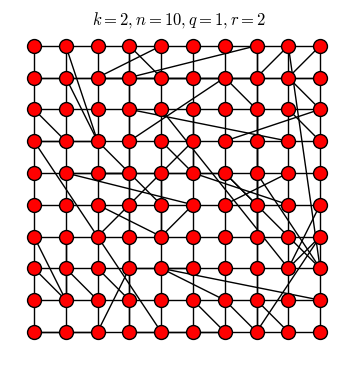

In [3]:
plt.rcParams['figure.figsize'] = (4,4)
G = nx.navigable_small_world_graph(10, p=1, q=1, r=2, dim=2)
G = G.to_undirected()
pos=draw_autocrop_grid(G)
nx.draw(G, pos=dict(zip(G,G)), node_size=100, node_color='r')
plt.title("$k=2, n=10, q=1, r=2$")

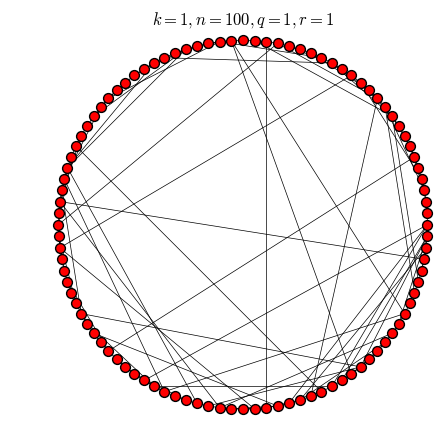

In [35]:
plt.rcParams['figure.figsize'] = (5,5)
G = kleinberg_ring(100, p=1, q=1, r=1)
pos = draw_autocrop(G)
nx.draw_circular(G, with_labels=False, node_size=50, node_color='r', width=0.5)
plt.title("$k=1, n=100, q=1, r=1$")

## 2.1 Kleinberg(2000) - Navigable small-world network model 
### 2.1.3 3つの定理
1. For $0 \leq r < k$, the delivery time of any decentralized algorithm in the grid-based model is $\Omega(n^{(2-r)/3)})$
2. For $r=k$, there is a decentralized algorithm with delivery time $O(\log^2 n)$
3. For $k \leq r$, the delivery time of any decentralized algorithm in the grid-based model is $\Omega(n^{(r-2)/(r-1))})$

## 2.1 Kleinberg(2000) - Navigable small-world network model 
### 1次元の場合

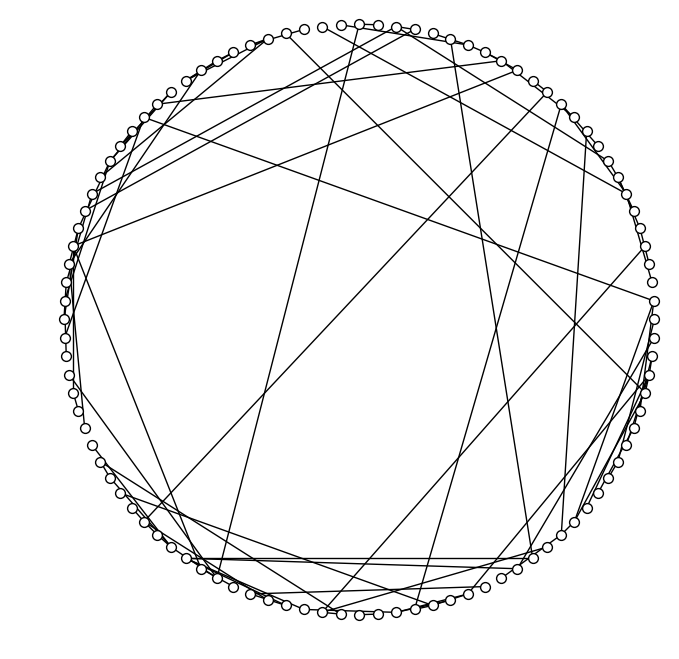

In [11]:
plt.rcParams['figure.figsize'] = (8,8)
G = kleinberg_ring(100, p=0, q=1, r=1)
pos = draw_autocrop(G)
nx.draw_circular(G, with_labels=False, node_size=50, node_color='w', font_size=8)

## 2.1 Kleinberg(2000) - Navigable small-world network model 
### 2次元の場合

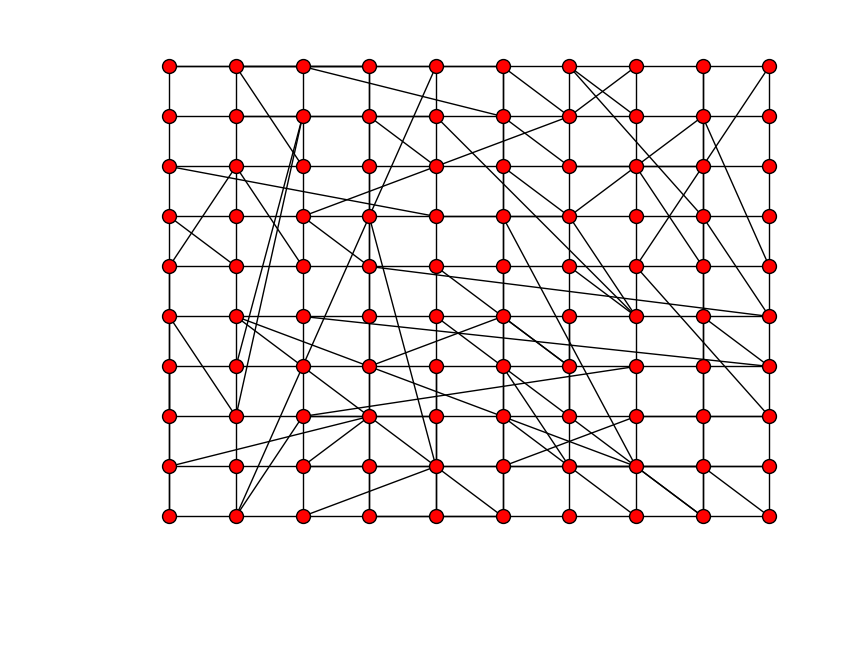

In [6]:
plt.rcParams['figure.figsize'] = (8,6)
G = nx.navigable_small_world_graph(10, p=1, q=1, r=2, dim=2)
G = G.to_undirected()
#nx.draw_networkx(G, pos=dict(zip(G,G)), node_size=100, font_size=8)
nx.draw(G, pos=dict(zip(G,G)), node_size=100, node_color='r')

## 2.2 Sandberg(2005) - Distributed routing in small-world networks
### Idea
- スモール・ワールドネットワーク上でのルーティング→P2Pオーバーレイネットワーク上でのルーティング
- F2F(Friend-to-friend): セキュリティ、プライバシー保護のため、各ノードは現実世界で信用のおけるノードとのみ通信。P2Pの一形態。
- Kleinberg(2000)では各ノードが自分の格子上での位置を知っていることが前提となっている
    - コンピュータのオーバーレイネットワークではこの前提が成り立たない。
    - 各ノードに格子上の位置を知らせる必要がある

## 2.2 Sandberg(2005) - Distributed routing in small-world networks
### Node switching
- Metropolis-Hastings法を用いて、Kleinbergモデルへの最適な写像をサンプリング

# 3. 問題設定
